In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Project - 1 | Machine Learning/combinedcsv.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Drop columns containing only a single value
columns_drop = list()
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 1:
        columns_drop.append(column)

df.drop(columns_drop, axis=1, inplace=True)
print(f"Dropped columns: {len(columns_drop)}", columns_drop)

# Separate the target variable ('malicious' column)
X = df.drop(columns=['malicious', 'md5_hash'])
y = df['malicious']

# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

param_grid_logistic = {
    'C': [1],  # Regularization strength
    'penalty': ['l1'],
    'solver': ['liblinear']  # Solver that supports L1 penalty
}

gs_logistic = GridSearchCV(LogisticRegression(), param_grid_logistic, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
gs_logistic.fit(X_train, y_train)

# Use the best estimator to identify important features
best_logistic = gs_logistic.best_estimator_
important_features = np.where(best_logistic.coef_[0] != 0)[0]

# Select only the important features for the Random Forest model
X_train_selected = X_train[:, important_features]
X_valid_selected = X_valid[:, important_features]
X_test_selected = X_test[:, important_features]

Dropped columns: 295 ['ACCESS_BLOBS_ACROSS_USERS', 'BIND_CARRIER_MESSAGING_CLIENT_SERVICE', 'BIND_COMPANION_DEVICE_SERVICE', 'BIND_CONTROLS', 'BIND_QUICK_ACCESS_WALLET_SERVICE', 'BIND_TV_INTERACTIVE_APP', 'BIND_VISUAL_VOICEMAIL_SERVICE', 'BODY_SENSORS_BACKGROUND', 'DELIVER_COMPANION_MESSAGES', 'HIDE_OVERLAY_WINDOWS', 'LAUNCH_MULTI_PANE_SETTINGS_DEEP_LINK', 'LOADER_USAGE_STATS', 'MANAGE_MEDIA', 'MANAGE_ONGOING_CALLS', 'MANAGE_WIFI_INTERFACES', 'MANAGE_WIFI_NETWORK_SELECTION', 'NEARBY_WIFI_DEVICES', 'NFC_PREFERRED_PAYMENT_INFO', 'READ_ASSISTANT_APP_SEARCH_DATA', 'READ_BASIC_PHONE_STATE', 'READ_HOME_APP_SEARCH_DATA', 'READ_NEARBY_STREAMING_POLICY', 'READ_VOICEMAIL', 'REQUEST_COMPANION_PROFILE_APP_STREAMING', 'REQUEST_COMPANION_PROFILE_AUTOMOTIVE_PROJECTION', 'REQUEST_COMPANION_PROFILE_COMPUTER', 'REQUEST_COMPANION_PROFILE_WATCH', 'REQUEST_COMPANION_SELF_MANAGED', 'REQUEST_COMPANION_START_FOREGROUND_SERVICES_FROM_BACKGROUND', 'REQUEST_OBSERVE_COMPANION_DEVICE_PRESENCE', 'SMS_FINANCIAL_TRAN

In [6]:
param_grid = {
    "booster": ["gbtree"]
    #"booster": ["gbtree", "gblinear", "dart"]
}

# Initialize GridSearchCV
gs_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=3, error_score=0, n_jobs=-1)

# Perform GridSearchCV to find the best hyperparameters
gs_xgb.fit(X_train_selected, y_train)

print("Best Params: ", gs_xgb.best_params_)

# Initialize and train the Linear Discriminant Analysisi classifier on the training data
clf_xgb = XGBClassifier(**gs_xgb.best_params_)
clf_xgb.fit(X_train_selected, y_train)

# Make predictions on the train data
y_train_pred = clf_xgb.predict(X_train_selected)

# Evaluate the model on the train data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Make predictions on the validation data
y_valid_pred = clf_xgb.predict(X_valid_selected)

# Evaluate the model on the validation data
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy:", valid_accuracy)

# Make predictions on the test data
y_test_pred = clf_xgb.predict(X_test_selected)

# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Testing):")
print(confusion)

classification_rep = classification_report(y_test, y_test_pred)
print("Classification Report (Testing):")
print(classification_rep)

Best Params:  {'booster': 'gbtree'}
Training Accuracy: 0.9953960571361115
Validation Accuracy: 0.9757773213400383
Testing Accuracy: 0.978468730080034
Confusion Matrix (Testing):
[[6207  100]
 [ 204 7608]]
Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6307
           1       0.99      0.97      0.98      7812

    accuracy                           0.98     14119
   macro avg       0.98      0.98      0.98     14119
weighted avg       0.98      0.98      0.98     14119



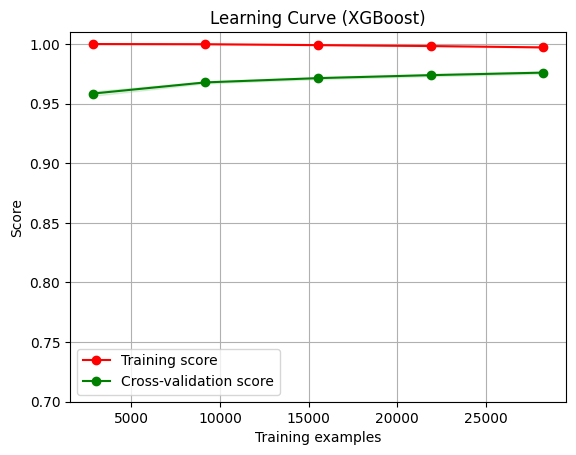

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve
title = "Learning Curve (XGBoost)"
plot_learning_curve(clf_xgb, X_train_selected, y_train, title=title, ylim=(0.7, 1.01), cv=3, n_jobs=-1)

# Display the plot
plt.show()